
**Install requirements**

In [ ]:
!python -m pip install -U pip
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

     |████████████████████████████████| 1.5MB 4.4MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 734.6 MB 22 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.8.1+cu101 requires torch==1.7.0, but you have torch 1.3.1 which is incompatible.
     |████████████████████████████████| 4.0 MB 5.9 MB/s 
     |████████████████████████████████| 753.4 MB 21 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1
  Attempting uninstall: torchvision
    Found existing installation: torchv

**Import libraries**

In [ ]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm
from torchvision.models.utils import load_state_dict_from_url
from torch.autograd import Function
from torchvision.datasets import VisionDataset
import matplotlib.pyplot as plt
import math


**Function used to plot the loss and accuracy**

In [ ]:
def plotting(loss_train, loss_val, acc_train, acc_val):

  epochs=len(loss_train)
  x=[i+1 for i in range(epochs)]
  x_div=int(epochs/6)
  xdisp=[i for i in range(epochs) if i%x_div==1]
  
  plt.figure()
  plt.plot(x, loss_train, 'r', label='Training loss')
  plt.plot(x, loss_val, 'b', label='Test loss')
  plt.legend()
  plt.xlabel('Epochs')
  plt.xticks(xdisp)
  plt.savefig('Losses', format='png')

  plt.figure()
  plt.plot(x, acc_train, 'r', label='Training accuracy')
  plt.plot(x, acc_val, 'b', label='Test accuracy')
  plt.legend()
  plt.xticks(xdisp)
  plt.xlabel('Epochs')


**Functions implementing the logic to load the database**

In [ ]:
class Caltech(VisionDataset):

    def __init__(self, root, split,stage=None, transform=None, target_transform=None):

        self.images =[]
        self.indexes = {}
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)
        self.split = split # This defines the split you are going to use
                           # (split files are called 'train.txt' and 'test.txt')
        skip = False
        import os
        self.path=root
        self.split=split
        if self.split=='train':
          self.path=self.path+'/photo'
        if self.split=='test':
          self.path=self.path+'/art_painting'
        if self.split=='val1':
          self.path=self.path+'/cartoon'
        if self.split=='val2':
          self.path=self.path+'/sketch'
        i=0
        for obj in os.listdir(f'{self.path}'):
          label=obj
          for im in os.listdir(self.path+'/'+obj):
              path=self.path+'/'+obj+'/'+im
              image=pil_loader(path)
              self.images.append((image, label))
              if label not in self.indexes.keys():
                self.indexes[label]=i
                i += 1

    def __getitem__(self, index):
        image, label = self.images[index][0], self.indexes[self.images[index][1]]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.images)

**Functions that modify Alexnet**

In [ ]:
__all__ = ['AlexNet', 'alexnet']


def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):

        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        self.classifier_d = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2))

    def forward(self, x, training, alpha=None):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        if training=='s':
            x = self.classifier(x)
        else:
            if training=='d':
                x = ReverseLayerF.apply(x, alpha)
                x = self.classifier_d(x)
        return x

def alexnet(pretrained=False, progress=True, **kwargs):
    
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'], progress=progress)
        model.load_state_dict(state_dict, strict=False)
        model.classifier_d[1].weight.data = model.classifier[1].weight.data
        model.classifier_d[1].bias.data = model.classifier[1].bias.data
        model.classifier_d[4].weight.data = model.classifier[4].weight.data
        model.classifier_d[4].bias.data = model.classifier[4].bias.data
        model.classifier_d[6].weight.data = model.classifier[6].weight.data
        model.classifier_d[6].bias.data = model.classifier[6].bias.data
    return model





**Function that reads the dataset**

In [ ]:
def init(pre_trained, batchsize, step=None):

  if pre_trained==True:
    train_transform = transforms.Compose([transforms.Resize(256),      
                                        transforms.CenterCrop(224), 
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ])
    eval_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                                     
    ])
  if pre_trained==False:
    train_transform = transforms.Compose([transforms.Resize(256),      
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(), 
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                 
    ])
    eval_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                         ])

  if not os.path.isdir('PACS'):
    !git clone https://github.com/MachineLearning2020/Homework3-PACS.git
    !mv 'Homework3-PACS' 'PACS'

  if not os.path.isdir('./Caltech101'):
    !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
    !mv 'Homework2-Caltech101' 'Caltech101'

  DATA_DIR = 'PACS/PACS'

  train = Caltech(DATA_DIR, split='train', transform=train_transform)
  test= Caltech(DATA_DIR, split='test',  transform=eval_transform)
  val1=Caltech(DATA_DIR, split='val1',  transform=eval_transform)
  val2=Caltech(DATA_DIR, split='val2',  transform=eval_transform)

  print('Train Dataset: {}'.format(len(train)))
  print('Test Dataset: {}'.format(len(test)))
  print('Val1 Dataset: {}'.format(len(val1)))
  print('Val2 Dataset: {}'.format(len(val2)))

  train_dataloader = DataLoader(train, batch_size=batchsize, shuffle=True, num_workers=4)
  test_dataloader = DataLoader(test, batch_size=batchsize, shuffle=False, num_workers=4) 
  val1_dataloader=DataLoader(val1, batch_size=batchsize, shuffle=False, num_workers=4)
  val2_dataloader=DataLoader(val2, batch_size=batchsize, shuffle=False, num_workers=4)

  if pre_trained==True:
    net=alexnet(pretrained=True)
  else:
    net = alexnet().cuda()
  
  net.classifier[6] = nn.Linear(4096, 7)

  return net, train_dataloader, test_dataloader, val1_dataloader, val2_dataloader, train, test, val1, val2

**Training the network**

In [ ]:
def train_net(net, layer, train_dataloader, test_dataloader, train_dataset, test_dataset, NUM_CLASSES, BATCH_SIZE,LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY, alpha, discriminator=False, val1_dataloader=None, val2_dataloader=None, val1=None, val2=None, gammap=None):

  criterion = nn.CrossEntropyLoss() 

  if layer=='all':
    parameters_to_optimize = net.parameters() 
  if layer=='fully':
    parameters_to_optimize=net.classifier.parameters()
  if layer=='conv':
    parameters_to_optimize=net.features.parameters()

  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  #optimizer = optim.Adam(parameters_to_optimize, lr=LR)
 
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
  net = net.to(DEVICE)

  loss_train=[]
  loss_test=[]
  acc_train=[]
  acc_test=[]
  loss_discriminator=[]
  cudnn.benchmark 

  if discriminator==False:

    for epoch in range(NUM_EPOCHS):
      current_step = 0
      print(f'epoch {epoch}')

      running_corrects = 0
      train_loss=0
      
      for images, labels in train_dataloader:
          
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        net.train()
        optimizer.zero_grad() 

        outputs = net(images, training="s")
        loss_1 = criterion(outputs, labels)
        loss_1.backward()
        train_loss+=loss_1.item()
        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()

        optimizer.step()
      
      acc=running_corrects/float(len(train_dataset))
      loss=train_loss/float(len(train_dataloader))

      acc_train.append(acc)
      loss_train.append(loss)
      '''
      print(f'Training accuracy, {acc}')
      print(f'Training loss, {loss}')
      '''
      net = net.to(DEVICE)
      net.train(False)

      running_corrects = 0
      test_loss=0

      for images, labels in test_dataloader:
        
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = net(images, training="s")
        test_loss+= criterion(outputs, labels).item()
        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()

      accuracy = running_corrects / float(len(test_dataset))
      loss=test_loss/float(len(test_dataloader))
      '''
      print(f'accuracy validation: {accuracy}')
      print(f'Loss test: {loss}')
      '''
      acc_test.append(accuracy)
      loss_test.append(loss)
      
    return acc_train, loss_train, acc_test, loss_test

  else:

    best_acc=0
    for epoch in range(NUM_EPOCHS):

      current_step = 0
      print(f'epoch {epoch}')

      running_corrects_train = 0
      running_corrects_test= 0
      train_loss=0
      test_loss=0
      loss_d=0

      print(gammap)
      rho=epoch/NUM_EPOCHS
      print(rho)
      alpha=2/(1+math.exp(-1*gammap*rho))-1
      dataloader_iterator = iter(train_dataloader)

      for images, labels in test_dataloader:

        try: 

          images_train, labels_train=next(dataloader_iterator)
          images_train = images_train.to(DEVICE)
          labels_train = labels_train.to(DEVICE)
          net.train() 
          optimizer.zero_grad()
          outputs = net(images_train, training="s")
          loss_1 = criterion(outputs, labels_train)
          loss_1.backward()
          train_loss+=loss_1.item()
          _, preds = torch.max(outputs.data, 1)
          running_corrects_train += torch.sum(preds == labels_train.data).data.item()
          labels_d = torch.tensor([0]*len(images_train)).to(DEVICE)
          outputs = net(images_train, training="d", alpha=alpha)
          loss_2 = criterion(outputs, labels_d)
          loss_d+=loss_2.item()
          loss_2.backward()  
        except:
          pass

        net.train()
        images= images.to(DEVICE)
        labels_di = torch.tensor([1]*len(images)).to(DEVICE)
        outputs= net(images, training="d", alpha=alpha)
        loss_3 = criterion(outputs, labels_di)
        loss_d+=loss_3.item()
        loss_3.backward()
        optimizer.step()
        net.train(False)
        labels = labels.to(DEVICE)
        outputs = net(images, training="s")
        test_loss+= criterion(outputs, labels).item()
        _, preds = torch.max(outputs.data, 1)
        running_corrects_test += torch.sum(preds == labels.data).data.item()

      accuracy = running_corrects_train / float(len(train_dataset))
      loss=train_loss/float(len(train_dataloader))
      loss_discriminator.append(loss_d/float(len(train_dataset)))
      acc_train.append(accuracy)
      loss_train.append(loss)
      print(f'accuracy train: {accuracy}')
      print(f'Loss train: {loss}')
      print(f'Loss discriminator: {loss_d}')
      print(f'Alpha: {alpha}')
      accuracy = running_corrects_test / float(len(test_dataset))
      if accuracy>best_acc:
        best_acc=accuracy
      loss=test_loss/float(len(test_dataloader))
      acc_test.append(accuracy)
      loss_test.append(loss)
      print(f'accuracy test: {accuracy}')
      print(f'Loss test: {loss}')

        
    print('best accuracy')
    print(best_acc)    
    return acc_train, loss_train, acc_test, loss_test, loss_discriminator




**Hyperparameters**

In [ ]:
DEVICE = 'cuda' 
NUM_CLASSES = 7 
BATCH_SIZE = 32     
LR = 1e-4 
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-5 
NUM_EPOCHS=30 
STEP_SIZE=20      
GAMMA = 0.1 
LOG_FREQUENCY = 10
typeNet='AlexNet'
layer='all'
gammap=0.5
discriminator=False
alpha=0.1

**Loading, training, evaluating, testing the network and plotting the loss and the accuracy**

In [ ]:
from sklearn.model_selection import ParameterGrid
param_grid = {'LR': [1e-4, 1e-3, 1e-2], 'NUM_EPOCHS': [20, 35, 50]}

Train Dataset: 1670
Test Dataset: 2048
Val1 Dataset: 2344
Val2 Dataset: 3929
{'LR': 0.0001, 'NUM_EPOCHS': 20}
loss train, loss_test, acc_train, acc_test
0.022887273568589734 4.51480142893018 0.9952095808383233 0.24267578125
Train Dataset: 1670
Test Dataset: 2048
Val1 Dataset: 2344
Val2 Dataset: 3929
{'LR': 0.0001, 'NUM_EPOCHS': 35}
loss train, loss_test, acc_train, acc_test
0.01168618131569534 4.641700630856527 0.9976047904191617 0.26611328125
Train Dataset: 1670
Test Dataset: 2048
Val1 Dataset: 2344
Val2 Dataset: 3929
{'LR': 1e-05, 'NUM_EPOCHS': 20}
loss train, loss_test, acc_train, acc_test
0.18718441308669323 2.8195097815950176 0.9449101796407186 0.21142578125
Train Dataset: 1670
Test Dataset: 2048
Val1 Dataset: 2344
Val2 Dataset: 3929
{'LR': 1e-05, 'NUM_EPOCHS': 35}
loss train, loss_test, acc_train, acc_test
0.11188308989523717 3.024567912861302 0.9700598802395209 0.22412109375


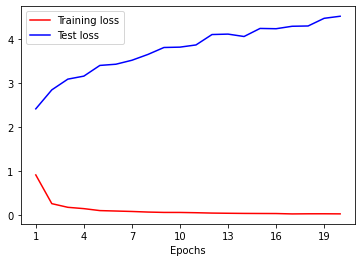

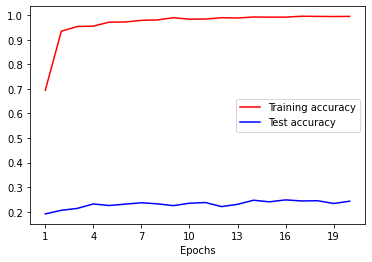

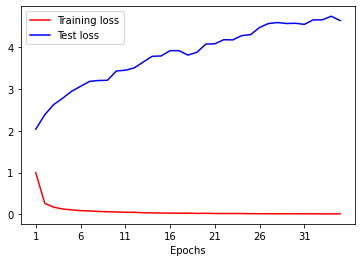

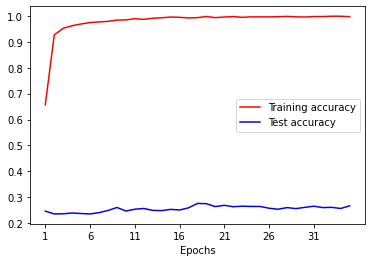

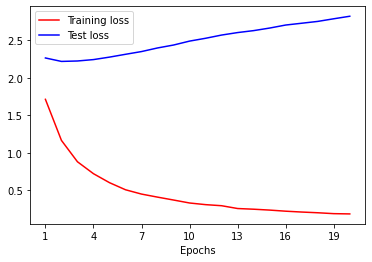

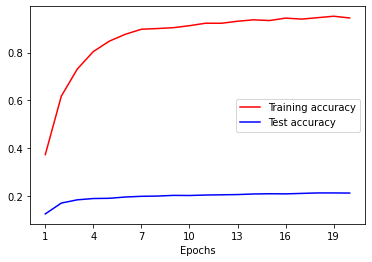

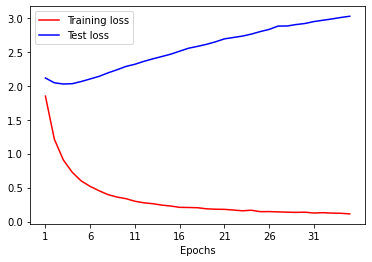

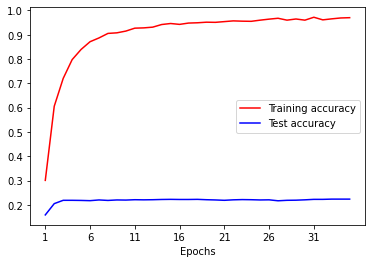

In [ ]:
from sklearn.model_selection import ParameterGrid
param_grid = {'LR': [1e-4, 1e-3, 1e-2], 'NUM_EPOCHS': [20, 35, 50]}

for p in list(ParameterGrid(param_grid)):  
  net, train_dataloader, test_dataloader, val1_dataloader, val2_dataloader, train, test, val1, val2=init(True, BATCH_SIZE)
  acc_train, loss_train, acc_test, loss_test,=train_net(net, layer, train_dataloader, test_dataloader, train, test, NUM_CLASSES, BATCH_SIZE,p['LR'], MOMENTUM, WEIGHT_DECAY, p['NUM_EPOCHS'], STEP_SIZE, GAMMA, LOG_FREQUENCY, alpha, discriminator, val1_dataloader, val2_dataloader, val1, val2, gammap)
  print(p)
  print('loss train, loss_test, acc_train, acc_test')
  print(loss_train[-1], loss_test[-1], acc_train[-1], acc_test[-1]) 
  plotting(loss_train, loss_test, acc_train, acc_test)
#net.classifier[6]=nn.Linear(4096,7)
#torch.nn.init.xavier_uniform(net.classifier[6].weight)


